In [41]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

#### Instead of normalizing data between 0 and 1, one normalizes them following so that to get a mean 0 and standard deviation 1.

In [42]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0, 1),
])

In [43]:
trainset = torchvision.datasets.MNIST(
    root='../data', 
    train=True, 
    download=True, 
    transform=transforms
)

In [44]:
testset = torchvision.datasets.MNIST(
    root='../data', 
    train=False, 
    download=True, 
    transform=transforms
)

In [45]:
trainset, valset = torch.utils.data.random_split(trainset, [len(trainset)-10000, 10000])

In [46]:
batch_size = 8192

In [47]:
train_loader = DataLoader(
    trainset,
    num_workers=2,
    batch_size=batch_size,
    shuffle=True
)

In [48]:
val_loader = DataLoader(
    valset,
    num_workers=2,
    batch_size=len(valset),
    shuffle=True
)
batch_idx, (xVal, yVal) = next(enumerate(val_loader))
xVal = torch.reshape(xVal, (len(valset), 28 * 28))

In [49]:
test_loader = DataLoader(
    testset,
    num_workers=2,
    batch_size=len(valset),
    shuffle=True
)
batch_idx, (xTest, yTest) = next(enumerate(test_loader))

In [50]:
class Autoencoder(nn.Module):
    
    def __init__(self, bottleneck):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 50)
        nn.init.xavier_uniform_(self.fc1.weight)
        
        self.fc2 = nn.Linear(50, bottleneck)
        nn.init.xavier_uniform_(self.fc2.weight) 

        self.fc3 = nn.Linear(bottleneck, 784)
        nn.init.xavier_uniform_(self.fc3.weight) 

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

# Training

In [ ]:
net1 = Autoencoder(2)
net2 = Autoencoder(4)

In [ ]:
epochs = 900

In [ ]:
LR = 0.0001

In [ ]:
loss_function = nn.MSELoss()

In [ ]:
val_frequency = 30
f = 0

loss_val1 = []
loss_val2 = []

loss_epoch1 = []
loss_epoch2 = []

loss_val_abscisse = []

In [ ]:
optimizer1 = torch.optim.Adam(net1.parameters(), lr=LR)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=LR)

In [ ]:
%%time
for epoch in range(epochs):
    for batch_idx, (xTrain, yTrain) in enumerate(train_loader): 
        xTrain = torch.reshape(xTrain, (len(xTrain), 28 * 28))
        
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        output1 = net1(xTrain)
        output2 = net2(xTrain)
        
        loss1 = loss_function(output1, xTrain)
        loss2 = loss_function(output2, xTrain)
            
        loss1.backward()
        loss2.backward()
        optimizer1.step()
        optimizer2.step()
        
        # Calculate loss validation every val_frequency iterations
        if f%val_frequency == 0:  
            with torch.no_grad():
                output_val1 = net1(xVal)
                output_val2 = net2(xVal)
                
                loss_val_item1 = loss_function(output_val1, xVal).item()
                loss_val_item2 = loss_function(output_val2, xVal).item()
              
            loss_val1.append(loss_val_item1)            
            loss_val2.append(loss_val_item2)
            
            loss_val_abscisse.append(epoch)
        f += 1
           
    loss_epoch1.append(loss1.item()) 
    loss_epoch2.append(loss2.item()) 
    if epoch%10 == 0:
        print('Epoch', epoch, 'training loss 1', loss1.item(), 'training loss 2', loss2.item())

## Save model

In [ ]:
torch.save({
            'epochs': epochs,
            'model_state_dict': net1.state_dict(),
            'loss_epoch1': loss_epoch1,
            'loss_val1': loss_val1,
            'loss_val_abscisse': loss_val_abscisse,
            }, "model/net1")

In [ ]:
torch.save({
            'epochs': epochs,
            'model_state_dict': net2.state_dict(),
            'loss_epoch2': loss_epoch2,
            'loss_val2': loss_val2,
            'loss_val_abscisse': loss_val_abscisse,
            }, "model/net2")

# Load model

In [19]:
net1 = Autoencoder(2)
net2 = Autoencoder(4)

In [20]:
checkpoint = torch.load("model/net1")
net1.load_state_dict(checkpoint['model_state_dict'])
epochs = checkpoint['epochs']
loss_epoch1 = checkpoint['loss_epoch1']
loss_val1 = checkpoint['loss_val1']
loss_val_abscisse = checkpoint['loss_val_abscisse']
net1.eval()

Autoencoder(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=784, bias=True)
)

In [21]:
checkpoint = torch.load("model/net2")
net2.load_state_dict(checkpoint['model_state_dict'])
loss_epoch2 = checkpoint['loss_epoch2']
loss_val2 = checkpoint['loss_val2']
net2.eval()

Autoencoder(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=784, bias=True)
)

# Plots

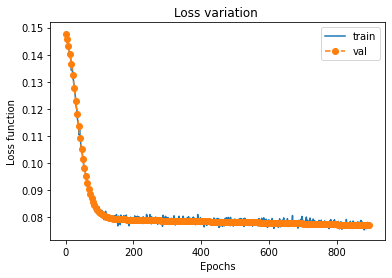

In [22]:
plt.plot(loss_epoch1, label="train")
plt.plot(loss_val_abscisse, loss_val1, '--o', label="val")
plt.title("Loss variation ")
plt.ylabel("Loss function")
plt.xlabel("Epochs")
plt.legend(loc="upper right")

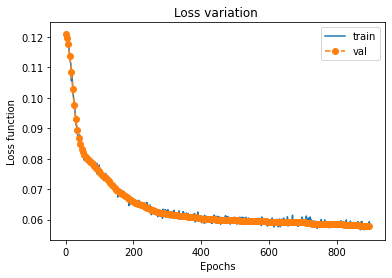

In [23]:
plt.plot(loss_epoch2, label="train")
plt.plot(loss_val_abscisse, loss_val2, '--o', label="val")
plt.title("Loss variation ")
plt.ylabel("Loss function")
plt.xlabel("Epochs")
plt.legend(loc="upper right")

# Train again

In [ ]:
epochs = 100
LR = 0.0001
loss_function = nn.MSELoss()
optimizer1 = torch.optim.Adam(net1.parameters(), lr=LR)
optimizer2 = torch.optim.Adam(net2.parameters(), lr=LR)

val_frequency = 30
f = 0

loss_val1 = []
loss_val2 = []

loss_epoch1 = []
loss_epoch2 = []

loss_val_abscisse = []

In [ ]:
%%time
for epoch in range(epochs):
    for batch_idx, (xTrain, yTrain) in enumerate(train_loader): 
        xTrain = torch.reshape(xTrain, (len(xTrain), 28 * 28))
        
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
        output1 = net1(xTrain)
        output2 = net2(xTrain)
        
        loss1 = loss_function(output1, xTrain)
        loss2 = loss_function(output2, xTrain)
            
        loss1.backward()
        loss2.backward()
        optimizer1.step()
        optimizer2.step()
        
        # Calculate loss validation every val_frequency iterations
        if f%val_frequency == 0:  
            with torch.no_grad():
                output_val1 = net1(xVal)
                output_val2 = net2(xVal)
                
                loss_val_item1 = loss_function(output_val1, xVal).item()
                loss_val_item2 = loss_function(output_val2, xVal).item()
              
            loss_val1.append(loss_val_item1)            
            loss_val2.append(loss_val_item2)
            
            loss_val_abscisse.append(epoch)
        f += 1
           
    loss_epoch1.append(loss1.item()) 
    loss_epoch2.append(loss2.item()) 
    if epoch%10 == 0:
        print('Epoch', epoch, 'training loss 1', loss1.item(), 'training loss 2', loss2.item())

In [ ]:
torch.save({
            'model_state_dict': net1.state_dict(),
            'loss_epoch1': loss_epoch1,
            'loss_val1': loss_val1,
            'loss_val_abscisse': loss_val_abscisse,
            }, "model/net1_retrain1")

In [ ]:
torch.save({
            'model_state_dict': net2.state_dict(),
            'loss_epoch2': loss_epoch2,
            'loss_val2': loss_val2,
            'loss_val_abscisse': loss_val_abscisse,
            }, "model/net2_retrain1")

# Load the best models

In [51]:
net1 = Autoencoder(2)
checkpoint = torch.load("model/net1_retrain1")
net1.load_state_dict(checkpoint['model_state_dict'])
net1.eval()

Autoencoder(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=784, bias=True)
)

In [52]:
net2 = Autoencoder(4)
checkpoint = torch.load("model/net2")
net2.load_state_dict(checkpoint['model_state_dict'])
net2.eval()

Autoencoder(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=784, bias=True)
)

# Test

In [53]:
xDigits = [
    xTest[yTest == 0][0], 
    xTest[yTest == 1][0], 
    xTest[yTest == 2][0], 
    xTest[yTest == 3][0], 
    xTest[yTest == 4][0],
    xTest[yTest == 6][0],
    xTest[yTest == 7][0],
    xTest[yTest == 8][0],
    xTest[yTest == 9][0]
]

In [54]:
def show(inputs, net):  
    outputs = net(torch.reshape(inputs, (len(inputs), 28 * 28)))
    outputs = torch.reshape(outputs, (len(outputs), 28, 28))
    fig, axes = plt.subplots(len(inputs), 2, sharex=True, sharey=True, figsize = (15,20))
    for i, (input, output) in enumerate(zip(inputs, outputs)):
        axes[i, 0].imshow(input.numpy(), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(output.detach().numpy(), cmap='gray')
        axes[i, 1].set_title("Output")

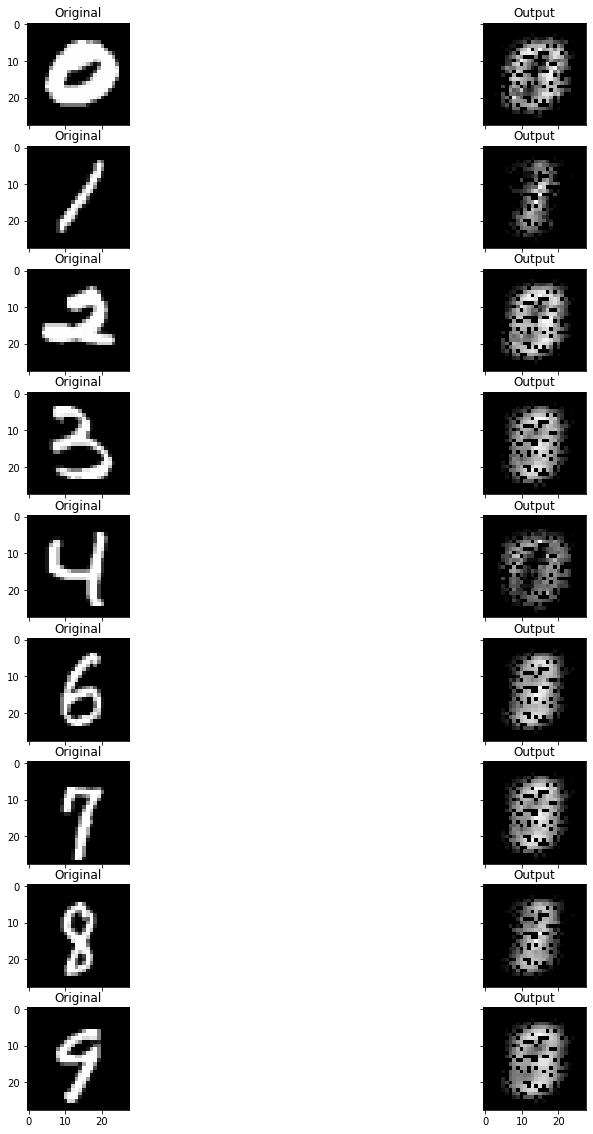

In [55]:
show(torch.cat(xDigits), net1)

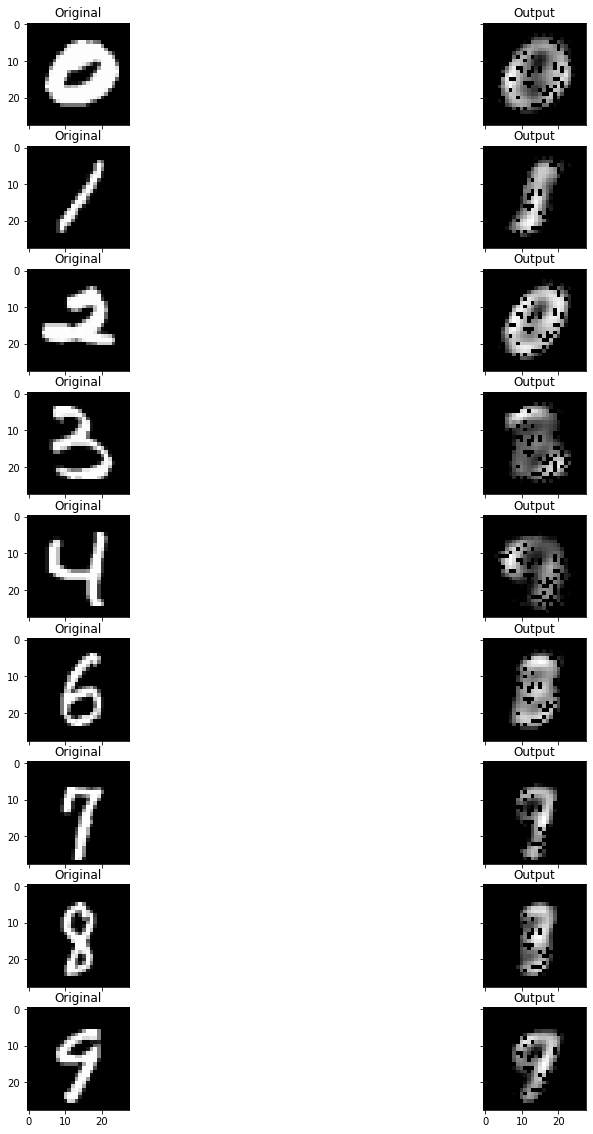

In [56]:
show(torch.cat(xDigits), net2)

# Encoders

In [1]:
class Encoder(nn.Module):
    
    def __init__(self, autoencoder):
        super(Encoder, self).__init__()
        self.fc1 = autoencoder.fc1
        self.fc2 = autoencoder.fc2

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

NameError: name 'nn' is not defined

In [106]:
batch_idx, (example_data, example_targets) = next(enumerate(train_loader))

In [59]:
encoder1 = Encoder(net1)
encoder2 = Encoder(net2)

## Encoder 1

In [60]:
output_bottleneck = encoder1(example_data.view(-1, 28 * 28))

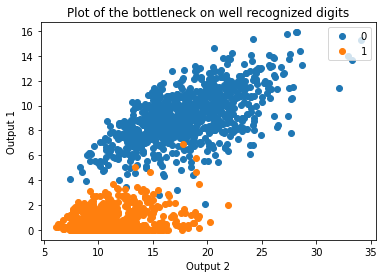

In [62]:
output_bottleneck_0 = output_bottleneck[example_targets == 0]
output_bottleneck_1 = output_bottleneck[example_targets == 1]
plt.plot(output_bottleneck_0.detach().numpy()[:,0],output_bottleneck_0.detach().numpy()[:,1],'o',label=0)
plt.plot(output_bottleneck_1.detach().numpy()[:,0],output_bottleneck_1.detach().numpy()[:,1],'o',label=1)
plt.title("Plot of the bottleneck on well recognized digits")
plt.ylabel("Output 1")
plt.xlabel("Output 2")
plt.legend(loc="upper right")

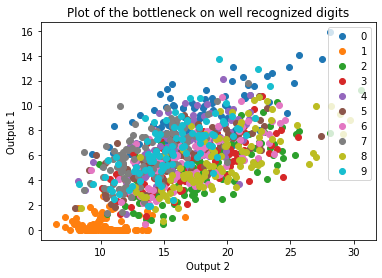

In [98]:
output_bottleneck = output_bottleneck[:1000]
example_targets = example_targets[:1000]
for digit in range(10):
    to_plot = output_bottleneck[example_targets == digit]
    plt.plot(to_plot.detach().numpy()[:,0],to_plot.detach().numpy()[:,1],'o',label=digit)
    
plt.title("Plot of the bottleneck on well recognized digits")
plt.ylabel("Output 1")
plt.xlabel("Output 2")
plt.legend(loc="upper right")

## Encoder 2

In [107]:
output_bottleneck = encoder2(example_data.view(-1, 28 * 28))

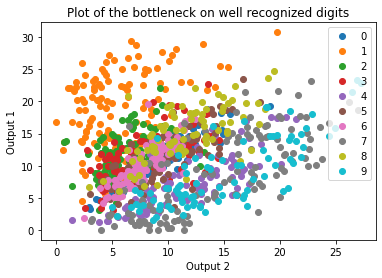

In [109]:
output_bottleneck = output_bottleneck[:1000]
example_targets = example_targets[:1000]
for digit in range(10):
    to_plot = output_bottleneck[example_targets == digit]
    plt.plot(to_plot.detach().numpy()[:,0],to_plot.detach().numpy()[:,1],'o',label=digit)
    
plt.title("Plot of the bottleneck on well recognized digits")
plt.ylabel("Output 1")
plt.xlabel("Output 2")
plt.legend(loc="upper right")

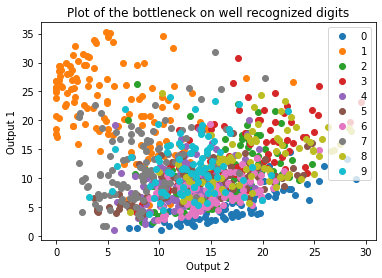

In [110]:
for digit in range(10):
    to_plot = output_bottleneck[example_targets == digit]
    plt.plot(to_plot.detach().numpy()[:,2],to_plot.detach().numpy()[:,3],'o',label=digit)
    
plt.title("Plot of the bottleneck on well recognized digits")
plt.ylabel("Output 1")
plt.xlabel("Output 2")
plt.legend(loc="upper right")

# Decoder

In [64]:
class Decoder(nn.Module):
    
    def __init__(self, autoencoder):
        super(Decoder, self).__init__()
        self.fc1 = autoencoder.fc3

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

## Decoder 1

In [86]:
decoder1 = Decoder(net1)

### Let's try to feed [10,0] in the decoder, a 1 should be retrieved

In [89]:
test_1 = torch.FloatTensor(np.array([[10,0]]))

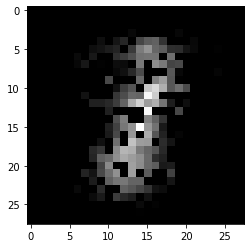

In [91]:
plt.imshow(torch.reshape(decoder1(test_1), (28, 28)).detach().numpy(), cmap='gray')

### Let's try to feed [20,10] in the decoder, a 0 should be retrieved

In [96]:
test_0 = torch.FloatTensor(np.array([[20,10]]))

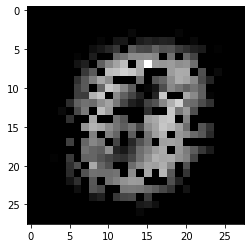

In [97]:
plt.imshow(torch.reshape(decoder1(test_0), (28, 28)).detach().numpy(), cmap='gray')

## Decoder 2

In [112]:
decoder2 = Decoder(net2)

In [113]:
test_0 = torch.FloatTensor(np.array([[8,10,15,2]]))
test_1 = torch.FloatTensor(np.array([[3,25,3,30]]))
test_2 = torch.FloatTensor(np.array([[5,13,20,15]]))
test_3 = torch.FloatTensor(np.array([[5,10,23,13]]))
test_4 = torch.FloatTensor(np.array([[15,10,10,5]]))
test_5 = torch.FloatTensor(np.array([[8,10,5,5]]))
test_6 = torch.FloatTensor(np.array([[8,10,15,5]]))
test_7 = torch.FloatTensor(np.array([[10,0,8,8]]))
test_8 = torch.FloatTensor(np.array([[13,17,20,10]]))
test_9 = torch.FloatTensor(np.array([[10,5,13,10]]))

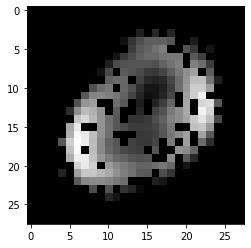

In [115]:
plt.imshow(torch.reshape(decoder2(test_0), (28, 28)).detach().numpy(), cmap='gray')

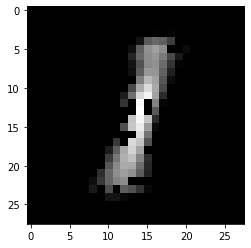

In [116]:
plt.imshow(torch.reshape(decoder2(test_1), (28, 28)).detach().numpy(), cmap='gray')

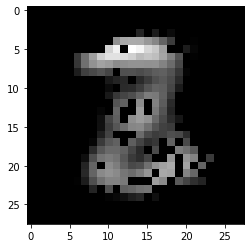

In [117]:
plt.imshow(torch.reshape(decoder2(test_2), (28, 28)).detach().numpy(), cmap='gray')

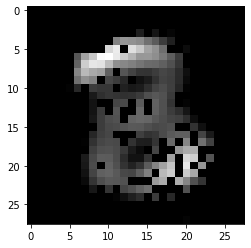

In [118]:
plt.imshow(torch.reshape(decoder2(test_3), (28, 28)).detach().numpy(), cmap='gray')

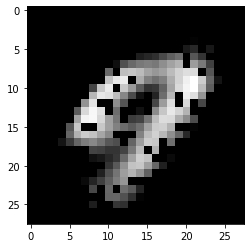

In [120]:
plt.imshow(torch.reshape(decoder2(test_4), (28, 28)).detach().numpy(), cmap='gray')

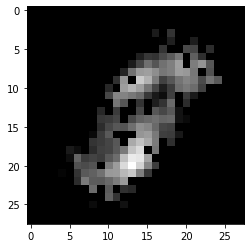

In [121]:
plt.imshow(torch.reshape(decoder2(test_5), (28, 28)).detach().numpy(), cmap='gray')

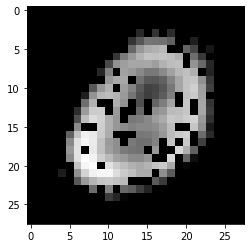

In [122]:
plt.imshow(torch.reshape(decoder2(test_6), (28, 28)).detach().numpy(), cmap='gray')

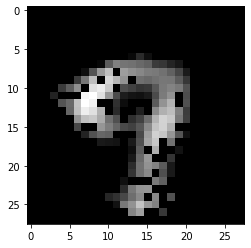

In [123]:
plt.imshow(torch.reshape(decoder2(test_7), (28, 28)).detach().numpy(), cmap='gray')

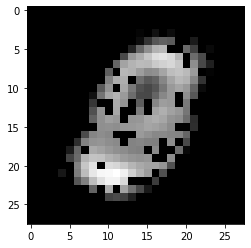

In [124]:
plt.imshow(torch.reshape(decoder2(test_8), (28, 28)).detach().numpy(), cmap='gray')

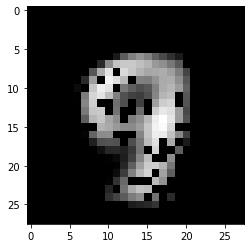

In [125]:
plt.imshow(torch.reshape(decoder2(test_9), (28, 28)).detach().numpy(), cmap='gray')